In [91]:
#Import Dependencies
import os
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, MetaData, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [92]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [93]:
Base = automap_base()

In [94]:
Base.prepare(engine, reflect=True)

In [95]:
Base.classes.keys()

['Measurements', 'Station']

In [96]:
Measurements = Base.classes.Measurements
Station = Base.classes.Station

In [97]:
session = Session(engine)

In [99]:
#Get Precipitation Data for the last year
prcp_year = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date >= (dt.date.today() - dt.timedelta(days=365))).all()

In [100]:
#Import query into DataFrame
prcp_df = pd.DataFrame(prcp_year, columns=['Date','Precipitation'])
prcp_df.set_index('Date', inplace=True)
prcp_df = prcp_df.dropna()
prcp_df.head()

,Precipitation
Date,
2017-04-07,0.0
2017-04-08,0.0
2017-04-09,0.0
2017-04-10,0.0
2017-04-11,0.0


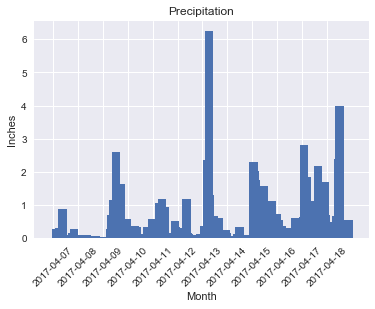

In [101]:
#Plot Precipitation Data
x = range(len(prcp_df.index.values))
y = prcp_df['Precipitation']

plt.bar(x, y,width=20)
labels= prcp_df.index.values
plt.xticks(range(len(prcp_df.index.values)), labels, rotation=45)
plt.title("Precipitation")
plt.locator_params(nbins=12, axis= 'x')
plt.ylabel('Inches')
plt.xlabel('Month')

plt.show()

In [102]:
#Query Total Stations
station_list = session.query(Station.id, Station.name).all()

station_name_df = pd.DataFrame(station_list, columns = ['ID', 'Name'])

print(f"There are {len(station_name_df['ID'])} stations.")

There are 9 stations.


In [103]:
#Query Total Station Observations
station_obs = [Measurements.station,
               func.count(Measurements.tobs)]

station_obs_query = session.query(*station_obs).\
                                group_by(Measurements.station).all()
    
station_obs_df = pd.DataFrame(station_obs_query, columns = ['Station', 'TotalObs'])

station_obs_df = station_obs_df.sort_values(by = 'TotalObs', ascending=False)

station_obs_df = station_obs_df.reset_index(drop=True)


print(f"{station_obs_df['Station'][0]} has the highest number of observations with {station_obs_df['TotalObs'][0]}.")


USC00519281 has the highest number of observations with 2772.


In [104]:
#Get Station with Max Reads
station_max = station_obs_df['Station'][0]

In [105]:
#Put observations into a data frame
max_obs = session.query(Measurements.station, Measurements.tobs, Measurements.date).\
    filter(Measurements.date >= (dt.date.today() - dt.timedelta(days=365))).\
    filter(Measurements.station == station_max ).all()

max_obs_df = pd.DataFrame(max_obs, columns=['Station','TotalObs','Date'])
max_obs_df.head(1)

,Station,TotalObs,Date
0,USC00519281,74,2017-04-07


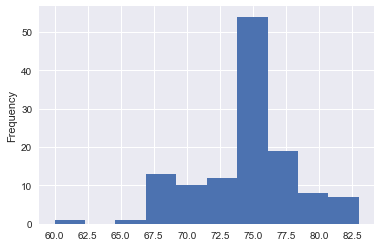

In [106]:
#Plot Graph
y = max_obs_df['TotalObs']

plt.hist(y)
labels= prcp_df.index.values
plt.locator_params(nbins=12, axis= 'x')
plt.ylabel('Frequency')
sns.set()
plt.show()

In [107]:
#Get min, max and average temps for date range
start_date = '2017-04-09'
end_date = '2017-05-10'

def calc_temp(start_date, end_date):
    
    minimum_temp = session.query(func.min(Measurements.tobs)).\
        filter(Measurements.date >= start_date).\
        filter(Measurements.date <= end_date).all()
    
    max_temp = session.query(func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).\
        filter(Measurements.date <= end_date).all()
    
    average_temp = session.query(func.avg(Measurements.tobs)).\
        filter(Measurements.date >= start_date).\
        filter(Measurements.date <= end_date).all()
    
    return minimum_temp, max_temp, average_temp

In [108]:
#Put return values into a dictionary
temp_trip = calc_temp(start_date, end_date)

Minimum = temp_trip[0][0][0]
Maximum = temp_trip[1][0][0]
Average = temp_trip[2][0][0]

temp_dict = {"Minimum":Minimum,
             "Maximum":Maximum,
             "Average":Average}
temp_dict

{'Average': 73.81725888324873, 'Maximum': 83, 'Minimum': 58}

Text(0.5,1,'Temperature Range')

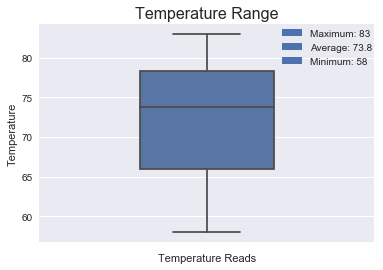

In [109]:
temp_df = pd.Series(temp_dict, index=temp_dict.keys())
sns.boxplot(y=temp_df, width=.4)
avg_patch = mpatches.Patch(label = 'Average: 73.8')
min_patch = mpatches.Patch(label = 'Minimum: 58')
max_patch = mpatches.Patch(label = 'Maximum: 83')
plt.legend(handles=[max_patch,avg_patch,min_patch], bbox_to_anchor=(1.02,1.02))
plt.xlabel('Temperature Reads')
plt.ylabel('Temperature')
plt.title('Temperature Range', size=16)